<a href="https://colab.research.google.com/github/AbhinavKoul/Pothole-Detection-Using-Convolutional-Neural-Networks/blob/Backend/Pothole_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
os.chdir("/content/drive/My Drive/Potholes Dataset")
!ls

'Dataset 1 (Simplex)'   README.txt	     'Subset 2 (Complex)'
'Dataset 2 (Complex)'  'Subset 1 (Simplex)'


REACHED REQUIRED DIRECTORY.

In [0]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import math
import random #rng
from PIL import Image #handle images
import matplotlib.pyplot as plt #plot data
from matplotlib.patches import Polygon #draw polygons on plots
import re #regex
from subprocess import check_output #run commands
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [57]:
class ImageData:
    def __init__(self, img_name, boxes):
        self.img_name = img_name
        self.boxes = boxes

def parse_directory(path):
    """Parse a directory containing negative images to a list of ImageData"""
    img_names = check_output(["ls", path]).decode("utf8").split("\n")
    data = []
    for img_name in img_names:
        match = re.search(r'G\d+\.JPG', img_name)
        if(match):
            data.append(ImageData(match.group(), []))
    return data
    
def parse_txt_file(filepath, filename):
    """Parse the txt file containing image relative paths, name, and boxes data to a list of ImageData"""
    file = open(filepath + filename)
    items = file.read().strip().split("\n")
    item_regex = r'(^[\w\s]+\\(?:[\w\s]+\\)*G\d+\.bmp)\s+(\d+)\s+((?:\d+\s+\d+\s+\d+\s+\d+\s*)+)'
    
    def parse_item(item):
        match = re.match(item_regex, item)
        
        img_path = match.group(1).replace('.bmp', '.JPG') #txt says bmp but images are actually jpg
        img_name = re.search(r'G\d+\.JPG', img_path).group()
        num_boxes = int(match.group(2))
        values = re.findall(r'\d+', match.group(3))
        boxes = [tuple([ int(values[i*4+j]) for j in range(0,4)]) for i in range(0,num_boxes)]
        
        return ImageData(img_name, boxes)
    
    return [parse_item(item) for item in items]


class ImageColleciton:
    def __init__(self, data, path):
        self.data = data
        self.path = path
        
src_path = "/content/drive/My Drive/Potholes Dataset/"    # file location
dataset2_path = src_path + "Dataset 2 (Complex)/"
dataset1_path = src_path + "Dataset 1 (Simplex)/"
print(dataset1_path)
print(dataset2_path)
img_collections = {
    "dataset2_complex": {
        "train": {
            "positive": ImageColleciton(
                parse_txt_file(dataset2_path, "complexTrainFullSizeAllPotholes.txt"),
                dataset2_path + "Train data/Positive data/"
            ),
            "negative": ImageColleciton(
                parse_directory(dataset2_path + "Train data/Negative data/"),
                dataset2_path + "Train data/Negative data/"
            )
        },
        "test": ImageColleciton( #test images have only positive data
            parse_txt_file(dataset2_path, "complexTestFullSizeAllPotholes.txt"),
            dataset2_path + "Test data/"
        ),
    },
    "dataset1_simplex": {
        "train": {
            "positive": ImageColleciton(
                parse_txt_file(dataset1_path, "simpleTrainFullPhotosSortedFullAnnotations.txt"),
                dataset1_path + "Train data/Positive data/"
            ),
            "negative": ImageColleciton(
                parse_directory(dataset1_path + "Train data/Negative data/"),
                dataset1_path + "Train data/Negative data/"
            )
        },
        "test": ImageColleciton( #test images have only positive data
            parse_txt_file(dataset1_path, "simpleTestFullSizeAllPotholesSortedFullAnnotation.txt"),
            dataset1_path + "Test data/"
        ),
    }
}

print("done " + str(random.random()))

/content/drive/My Drive/Potholes Dataset/Dataset 1 (Simplex)/
/content/drive/My Drive/Potholes Dataset/Dataset 2 (Complex)/
done 0.6229106580691227


In [58]:

IMG_W = 3680
IMG_H = 2760
CHANNELS = 3
CROP_X = (0,0) #take CROP_X[0] from the left and CROP_X[1] from the right
CROP_Y = (1000,800) #take CROP_Y[0] from the top and CROP_Y[1] from the bottom
cropped_img_w = IMG_W - CROP_X[0] - CROP_X[1]
cropped_img_h = IMG_H - CROP_Y[0] - CROP_Y[1]
pos_col = img_collections["dataset1_simplex"]["train"]["positive"]
neg_col = img_collections["dataset1_simplex"]["train"]["negative"]

def ImageCollection_to_full_paths(img_col):
    return [img_col.path + img.img_name for img in img_col.data]

def read_n_crop_img_from_path(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    cropped_img = image[CROP_Y[0]:IMG_H - CROP_Y[1], CROP_X[0]:IMG_W - CROP_X[1]]
    return cropped_img

def train_val_test_split(img_paths, labels, val_split, test_split):
    count_samples = len(labels)
    count_val = math.floor(count_samples * val_split)
    count_test = math.floor(count_samples * test_split)
    count_train = count_samples - count_val - count_val
    labels = list(labels)
    
    img_paths_val = []
    labels_val = []
    indexes_val = list(np.random.choice(count_samples, count_val, replace=False))
    indexes_val.sort(reverse=True)
    
    for i in indexes_val:
        img_paths_val.append(img_paths.pop(i))
        labels_val.append(labels.pop(i))
        
        img_paths_test = []
        
    count_samples = len(labels)
    labels_test = []
    indexes_test = list(np.random.choice(count_samples, count_test, replace=False))
    indexes_test.sort(reverse=True)
    
    for i in indexes_test:
        img_paths_test.append(img_paths.pop(i))
        labels_test.append(labels.pop(i))
        
    return img_paths, labels, img_paths_val, labels_val, img_paths_test, labels_test

def imageGenerator(img_full_paths, labels, batch_size):
    rand_indexes = []
    
    while True: 
        X_batch = np.ndarray((batch_size, cropped_img_h, cropped_img_w, CHANNELS), dtype=np.uint8)
        y_batch = np.ndarray((batch_size,))
        
        while(len(rand_indexes) < batch_size):
            more_indexes = list(range(0,len(img_full_paths)))
            random.shuffle(more_indexes)
            rand_indexes = more_indexes + rand_indexes
        
        for j in range(batch_size):
            i = rand_indexes.pop()
            X_batch[j] = read_n_crop_img_from_path(img_full_paths[i])
            y_batch[j] = labels[i]
            
        yield (X_batch, y_batch)


img_full_paths = ImageCollection_to_full_paths(pos_col) + ImageCollection_to_full_paths(neg_col)
labels = np.concatenate((np.ones(len(pos_col.data)), np.zeros(len(neg_col.data))))

img_paths_train, labels_train, img_paths_val, labels_val, img_paths_test, labels_test = train_val_test_split(img_full_paths, labels, 0.1, 0.01)    

print(len(img_paths_train))
print(len(img_paths_val))
print(len(img_paths_test))

4504
506
50


In [59]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/CNN Model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/CNN Model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
test_generator = imageGenerator(img_paths_test, labels_test, 20)

In [0]:
#X_test, y_test = next(test_generator)

In [62]:

X_test, y_test = next(test_generator)
def prep_imgs_for_plt(imgs):
    return [np.flip(img, 2) for img in imgs]
    
def avg_img(img_list):
    return np.array(img_list).mean(axis=0, dtype=np.uint32)

def show_img(img, text="", prep=True):
    if(prep):
        img = prep_imgs_for_plt([img])[0]
    fig, ax = plt.subplots(1, figsize=(25,25))
    ax.set_title(text)
    ax.imshow(img)

def apply_threshold(threshold, data):
    return [0 if item < threshold else 1 for item in data]
    
# show_img(avg_img(X_train), "Average train data image")
# rand_i = random.randrange(0, len(X_train))
# show_img(X_train[rand_i], f'Random image: {rand_i}')
s, e = 0,20
print(apply_threshold(0.5, loaded_model.predict(X_test[s:e], verbose=1)))
print(y_test[s:e])

20/20 [==============================] - 49s 2s/step
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]
[0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]


In [0]:
# s, e = 0,20
# print(apply_threshold(0.5, loaded_model.predict(X_test[s:e], verbose=1)))
# print(y_test[s:e])

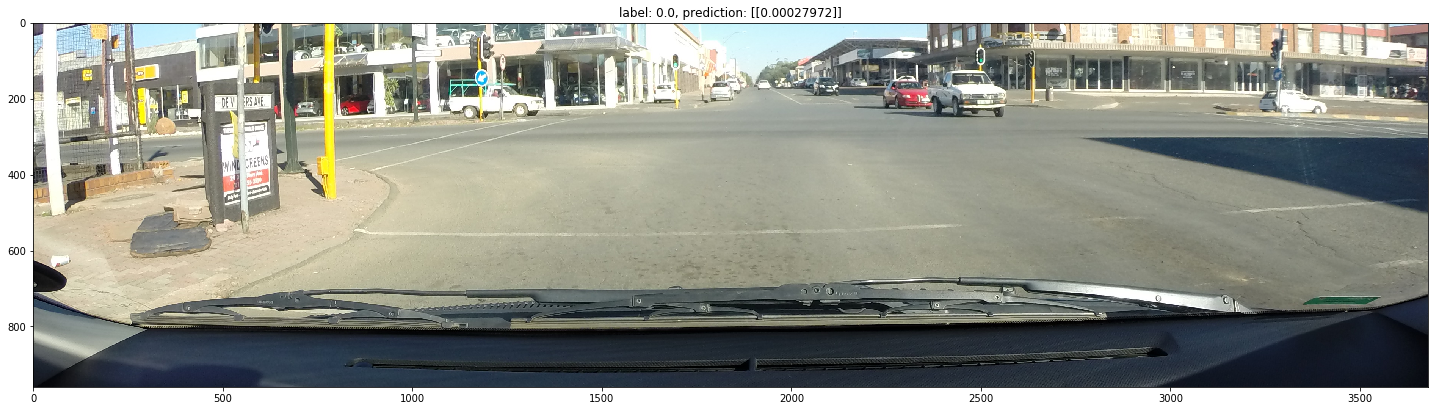

In [64]:
def display_prediction(X, y, index):
    image = X[index]
    label = y[index]
    pred = loaded_model.predict(np.expand_dims(image, axis=0))
    show_img(image, "label: {}, prediction: {}".format(label, pred))
    
display_prediction(X_test, y_test, 1)